# CrashStats Modeling

CrashStats data is provided to users by VicRoads for the purpose of supplying information about road crashes in Victoria for educational purposes.

The data provided allows users to analyse Victorian fatal and injury crash data based on time, location, conditions, crash type, road user type, object hit etc.

The data files are as follows:

Tables
- accident (basic accident details, time, severity, location)
- person (person based details, age, sex etc)
- vehicle (vehicle based data, vehicle type, make etc)
- accident_event (sequence of events e.g. left road, rollover, caught fire)
- road_surface_cond (whether road was wet, dry, icy etc)
- atmospheric_cond (rain, winds etc)
- sub_dca (detailed codes describing accident)
- accident_node (master location table - NB subset of accident table)
- Node Table with Lat/Long references

In this notebook we will build a benchmark model aimed at predicting accident severity

Importing necessary packages

In [486]:
import os
import sys
import glob
import re
from joblib import dump, load

import numpy as np
import pandas as pd
import scipy.stats as st
from statsmodels.miscmodels.ordinal_model import OrderedModel

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MultiLabelBinarizer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score, auc, \
classification_report, confusion_matrix, average_precision_score, precision_recall_curve

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets

Reading the data

In [346]:
path = os.path.join(os.getcwd(), 'ACCIDENT')
csv_files = glob.glob(os.path.join(path, "*.csv"))
data = {}

p = re.compile("([A-Z_]+)\.csv")
for file_path in csv_files:
    try:
        df_name = f'{p.search(file_path).groups()[0].lower()}_df'
    except:
        df_name = None
    print(df_name)
    if df_name is not None:
        locals()[df_name] = pd.read_csv(file_path)

accident_df


C:\Users\Ellie\AppData\Local\Temp\ipykernel_18324\3437032669.py:13: DtypeWarning: Columns (10,13) have mixed types. Specify dtype option on import or set low_memory=False.
  locals()[df_name] = pd.read_csv(file_path)


accident_chainage_df
accident_event_df
accident_location_df
atmospheric_cond_df
node_df
node_id_complex_int_id_df
person_df


C:\Users\Ellie\AppData\Local\Temp\ipykernel_18324\3437032669.py:13: DtypeWarning: Columns (6,9,10,13) have mixed types. Specify dtype option on import or set low_memory=False.
  locals()[df_name] = pd.read_csv(file_path)


road_surface_cond_df
None
subdca_df
vehicle_df


C:\Users\Ellie\AppData\Local\Temp\ipykernel_18324\3437032669.py:13: DtypeWarning: Columns (3,25,26,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  locals()[df_name] = pd.read_csv(file_path)


### Cleaning and formatting

In [347]:
# dealing with multiples types issue
accident_df.iloc[:, [10,13]] = accident_df.iloc[:, [10,13]].applymap(lambda x: str(x))
person_df.iloc[:, [6,9,10,13]] = person_df.iloc[:, [6,9,10,13]].applymap(lambda x: str(x))
vehicle_df.iloc[:, [3,25,26,35,36]] = vehicle_df.iloc[:, [3,25,26,35,36]].applymap(lambda x: str(x))

# converting datetime columns to datetime format
accident_df['ACCIDENTDATE'] = pd.to_datetime(accident_df['ACCIDENTDATE'], infer_datetime_format=True)
accident_df['ACCIDENTTIME'] = pd.to_datetime(accident_df['ACCIDENTTIME'], infer_datetime_format=True)

In [348]:
# getting rid of blank strings and leading/trailing spaces
for df in [accident_data, event_data, location_data, atmospheric_data, node_data, 
           node_complex_data, person_data, road_data, vehicle_data]:
    df = df.replace('^\s$', None, regex=True)
    df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

### Choosing columns to start off with
Here we isolate from each table the columns we deem as useful to our model.

To see the full column list for each table please refer to crashstats_eda.ipynb

In [467]:
# the columns we are choosing to include in our modeling
accident_columns = ['ACCIDENT_NO', 'ACCIDENTDATE', 'ACCIDENTTIME', 'Accident Type Desc', 'Day Week Description', 
                    'DCA Description', 'Light Condition Desc', 'NODE_ID', 'NO_OF_VEHICLES', 'NO_PERSONS', 
                    'POLICE_ATTEND', 'Road Geometry Desc', 'SEVERITY', 'SPEED_ZONE']
event_columns = ['ACCIDENT_NO', 'Event Type Desc', 'VEHICLE_1_ID', 'Vehicle 1 Coll Pt Desc', 
                 'VEHICLE_2_ID', 'Vehicle 2 Coll Pt Desc', 'PERSON_ID', 'OBJECT_TYPE', 'Object Type Desc']
location_columns = ['ACCIDENT_NO', 'NODE_ID', 'ROAD_TYPE', 'ROAD_TYPE_INT', 'DISTANCE_LOCATION', 'DIRECTION_LOCATION']
atmospheric_columns = ['ACCIDENT_NO', 'Atmosph Cond Desc']
node_columns = ['ACCIDENT_NO', 'NODE_ID', 'NODE_TYPE', 'LGA_NAME', 'REGION_NAME', 'DEG_URBAN_NAME']
node_complex_columns = ['ACCIDENT_NO', 'NODE_ID', 'COMPLEX_INT_NO']
person_columns = ['ACCIDENT_NO', 'PERSON_ID', 'VEHICLE_ID', 'SEX', 'AGE', 'SEATING_POSITION', 'HELMET_BELT_WORN', 'Road User Type Desc', 'LICENCE_STATE', 
                  'PEDEST_MOVEMENT', 'EJECTED_CODE', 'Inj Level Desc']
road_columns = ['ACCIDENT_NO', 'Surface Cond Desc']
vehicle_columns = ['ACCIDENT_NO', 'VEHICLE_ID', 'VEHICLE_YEAR_MANUF', 'VEHICLE_DCA_CODE', 'INITIAL_DIRECTION', 
                   'Road Surface Type Desc', 'REG_STATE', 'VEHICLE_BODY_STYLE', 'VEHICLE_MAKE', 'VEHICLE_MODEL', 
                   'Vehicle Type Desc', 'CONSTRUCTION_TYPE', 'FUEL_TYPE', 'NO_OF_WHEELS', 'NO_OF_CYLINDERS', 
                   'SEATING_CAPACITY', 'TARE_WEIGHT', 'TOTAL_NO_OCCUPANTS', 'CARRY_CAPACITY', 'CUBIC_CAPACITY', 
                   'FINAL_DIRECTION', 'DRIVER_INTENT', 'VEHICLE_MOVEMENT', 'TRAILER_TYPE', 'VEHICLE_COLOUR_1', 
                   'VEHICLE_COLOUR_2', 'CAUGHT_FIRE', 'INITIAL_IMPACT', 'LAMPS', 'Traffic Control Desc']

accident_data = accident_df[accident_columns]
event_data = accident_event_df[event_columns]
location_data = accident_location_df[location_columns]
atmospheric_data = atmospheric_cond_df[atmospheric_columns]
node_data = node_df[node_columns]
node_complex_data = node_id_complex_int_id_df[node_complex_columns]
person_data = person_df[person_columns]
road_data = road_surface_cond_df[road_columns]
vehicle_data = vehicle_df[vehicle_columns]

### Feature engineering
We'll start off with the whole accident table we isolated and add some more data for our model from the other tables:
- Year, month and hour of accident
- Mean ages for all persons in accident and all drivers in accident
- Number of female and male drivers in accident
- Indicator fields for atmospheric conditions, road conditions and event types
- Binary field for presence of complex intersection

We'll also take the following steps:
- Replace missing or dummy values (such as 999 in speed_zone) with -1
- Group low levels of certain columns (e.g. DCA code) into another category named "other"

In [421]:
data = accident_data.set_index('ACCIDENT_NO')

# datetime cols - treat as numeric
data['YEAR'] = data['ACCIDENTDATE'].dt.year
data['MONTH'] = data['ACCIDENTDATE'].dt.month
data['HOUR'] = data['ACCIDENTTIME'].dt.hour

# mean age of all involved and mean age of drivers
data['MEAN_AGE'] = person_data.groupby('ACCIDENT_NO')['AGE'].mean()
data['MEAN_DRIVER_AGE'] = person_data[person_data['Road User Type Desc']=='Drivers'].groupby('ACCIDENT_NO')['AGE'].mean()

# how many drivers from each sex
data[['NO_OF_FEMALE_DRIVERS', 'NO_OF_MALE_DRIVERS']] = person_df[person_data['Road User Type Desc']=='Drivers'].groupby(
    'ACCIDENT_NO')['SEX'].value_counts().unstack().fillna(0).drop(['U', ' '], axis=1)

# if our newly created numeric cols are nulls, that may mean there were no drivers in the accident
# filling nulls numeric cols with -1
new_cols = ['MEAN_AGE', 'MEAN_DRIVER_AGE', 'NO_OF_FEMALE_DRIVERS', 'NO_OF_MALE_DRIVERS']
data[new_cols] = data[new_cols].fillna(-1)

# MultiLabelBinarizing atmospheric conditions
atmospheric_data_to_join = atmospheric_data.groupby('ACCIDENT_NO')['Atmosph Cond Desc'].value_counts().unstack().fillna(0)
data = pd.concat([data, atmospheric_data_to_join], axis=1)

# MultiLabelBinarizing road conditions
road_data_to_join = road_data.groupby('ACCIDENT_NO')['Surface Cond Desc'].value_counts().unstack().fillna(0)
data = pd.concat([data, road_data_to_join], axis=1)

# MultiLabelBinarizing event type
event_data_to_join = event_data.groupby('ACCIDENT_NO')['Event Type Desc'].value_counts().unstack().fillna(0)
data = pd.concat([data, event_data_to_join], axis=1)

# was there a complex intersection in the accident
data['COMPLEX_INT'] = node_complex_data.groupby('ACCIDENT_NO')['COMPLEX_INT_NO'].any()

# getting rid of 999s on speed_zone
data['SPEED_ZONE'] = data['SPEED_ZONE'].replace(999, data['SPEED_ZONE'].mode()[0])

# binning low levels on DCA description
def bin_low_levels(s, thresh):
    vc = s.value_counts(normalize=True)
    return s.apply(lambda x: 'Other' if x not in vc[vc>thresh].index else x)

data['DCA Description'] = bin_low_levels(data['DCA Description'], 0.01)

# dropping the datetime columns and the rarely seen level 4 severity (no injured persons)
data.drop(['ACCIDENTDATE', 'ACCIDENTTIME', 'NODE_ID'], axis=1, inplace=True)
data = data[data['SEVERITY']!=4]

In [359]:
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Accident Type Desc,203704,9,Collision with vehicle,126652,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Day Week Description,203704,7,Friday,32240,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DCA Description,203704,26,Other,33468,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Light Condition Desc,203704,7,Day,136358,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NO_OF_VEHICLES,203704.0,NaN,NaN,NaN,1.793008,0.74932,1.0,1.0,2.0,2.0,21.0
NO_PERSONS,203704.0,NaN,NaN,NaN,2.410336,1.502417,1.0,2.0,2.0,3.0,97.0
POLICE_ATTEND,203704.0,NaN,NaN,NaN,1.276588,0.604635,1.0,1.0,1.0,2.0,9.0
Road Geometry Desc,203704,9,Not at intersection,103272,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SEVERITY,203704.0,NaN,NaN,NaN,2.627646,0.519715,1.0,2.0,3.0,3.0,3.0
SPEED_ZONE,203704.0,NaN,NaN,NaN,72.242582,63.111241,30.0,60.0,60.0,80.0,888.0


We'll attempt two kinds of models, binary models and ordinal regression models

For binary models we'll create a binary dependent variable, where:
1. Positive class = fatal and serious injury accidents (0 and 1)
2. Negative class = other injury accidents (2)

For the binary models we'll try two classification algorithms: logistic regression and random forest. For the ordinal regression we'll use logistic regression with immediate intervals.

First we have some preprocessing to do: We'll start by listing our numeric and categorical fields

In [360]:
# numeric fields
num_cols = ['NO_OF_PERSONS', 'NO_OF_VEHICLES', 'SPEED_ZONE', 'MEAN_AGE', 'MEAN_DRIVER_AGE', 'NO_OF_FEMALE_DRIVERS', 
            'NO_OF_MALE_DRIVERS', 'YEAR', 'MONTH', 'HOUR']

# categorical fields
cat_cols = ['Accident Type Desc', 'Day Week Description', 'DCA Description', 'Light Condition Desc', 'Road Geometry Desc',
            'COMPLEX_INT']

In [361]:
# casting our dependent variable 'y' as the SEVERITY column
y = data['SEVERITY']

# the values of y start at 1. For the ordinal model to work best we should start them at 0
y = y.apply(lambda x: x-1)

# dropping SEVERITY from our independent variables
data.drop('SEVERITY', axis=1, inplace=True)

In [466]:
# creating binary dependent variable
y_train_binary, y_test_binary = y_train.apply(lambda x: x<2), y_test.apply(lambda x: x<2)

The remainder of our preprocessing will include three steps:
1. One-hot encoding categorical variables
2. Standard scaling
3. Dimension reduction using Principle Component Analysis (PCA)

In [381]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2)

# one-hot encoding
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_train_ohe = X_train[cat_cols].to_numpy()
X_test_ohe = X_test[cat_cols].to_numpy()
ohe.fit(train_ohe_data)

X_train_ohe = ohe.transform(X_train_ohe)
X_train_ohe = pd.DataFrame(X_train_ohe, index=X_train.index, columns=ohe.get_feature_names_out())
X_test_ohe = ohe.transform(X_test_ohe)
X_test_ohe = pd.DataFrame(X_test_ohe, index=X_test.index, columns=ohe.get_feature_names_out())

X_train = pd.concat([X_train, X_train_ohe], axis=1).drop(cat_cols, axis=1)
X_test = pd.concat([X_test, X_test_ohe], axis=1).drop(cat_cols, axis=1)

# scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# dimension reduction
pca = PCA(0.95)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

(162963, 85) (40741, 85)
(162963, 66) (40741, 66)


In [468]:
def plot_roc_curve(test_ytrue, test_ypred, train_ytrue, train_ypred, save_path=None):
    test_fpr, test_tpr, test_thresh = roc_curve(test_ytrue, test_ypred, drop_intermediate=False)
    test_auc = auc(test_fpr, test_tpr)
    
    train_fpr, train_tpr, train_thresh = roc_curve(train_ytrue, train_ypred, drop_intermediate=False)
    train_auc = auc(train_fpr, train_tpr)

    plt.subplots(1, 1, figsize=(10, 7))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(test_fpr, test_tpr, label=f'test_auc = {test_auc:.3f}')
    plt.plot(train_fpr, train_tpr, label=f'train_auc = {train_auc:.3f}')

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    if save_path is not None:
        plt.savefig(save_path)
        
        
def plot_precision_recall_curve(ytrue, ypred, save_path=None):
    precision, recall, thresh = precision_recall_curve(ytrue, ypred)
    avgprec = average_precision_score(ytrue, ypred)

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    plt.plot([0, 1], [1, 0], 'k--')
    plt.plot(precision, recall, label=f'Avg Precision Score = {avgprec:.3f}')
    ax.set_xlabel('Precision')
    ax.set_ylabel('Recall')
    plt.title('Precision-Recall curve')
    plt.legend(loc='best')
    if save_path is not None:
        plt.savefig(save_path)
        
        
def plot_confusion_matrix(cm, save_path=None):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    colors = sns.light_palette('blue', as_cmap=True)
    cm_disp = sns.heatmap(cm, cmap=colors, annot=True, fmt='g', cbar=False)
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Real Values')
    if save_path is not None:
        plt.savefig(save_path)

### Logistic regression binary classifier

In [401]:
# defining the model; hyperparameters tuned: C (regularization parameter)
binary_lr_model = LogisticRegressionCV(Cs=10, cv=5, class_weight='balanced', random_state=0, max_iter=1000, verbose=3, n_jobs=3)
binary_lr_model.fit(X_train, y_train_binary)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   5 | elapsed:    4.9s remaining:    7.4s
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:   13.2s finished


LogisticRegressionCV(class_weight='balanced', cv=5, max_iter=1000, n_jobs=3,
                     random_state=0, verbose=3)

In [493]:
# saving model
dump(binary_lr_model, '../models/binary_lr_clf.joblib');

#### Logistic regression predictions and metrics

              precision    recall  f1-score   support

       False       0.76      0.61      0.68     26325
        True       0.48      0.65      0.55     14416

    accuracy                           0.62     40741
   macro avg       0.62      0.63      0.61     40741
weighted avg       0.66      0.62      0.63     40741



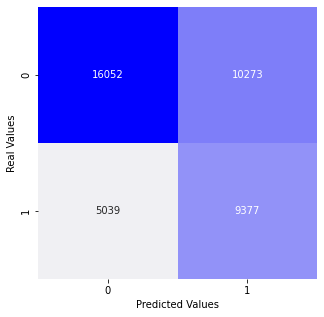

In [473]:
binary_lr_pred = binary_lr_model.predict(X_test)
binary_lr_train_pred = binary_lr_model.predict(X_train)

cr = classification_report(y_test_binary, binary_lr_pred)
cm = confusion_matrix(y_test_binary, binary_lr_pred)
print(cr)
plot_confusion_matrix(cm)

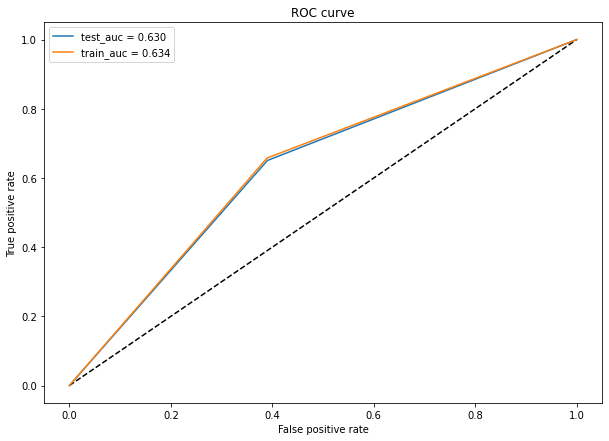

In [475]:
plot_roc_curve(y_test_binary, binary_lr_pred, y_train_binary, binary_lr_train_pred)

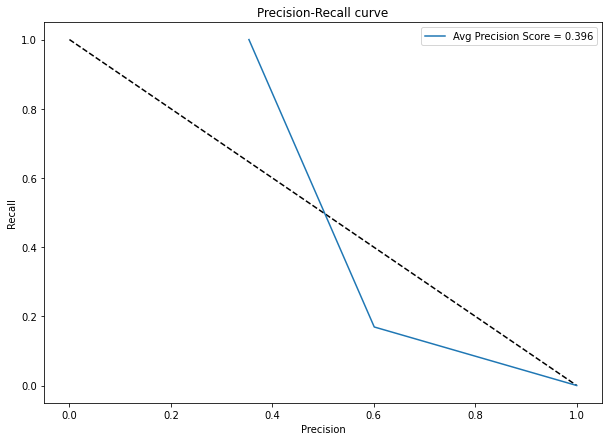

In [477]:
plot_precision_recall_curve(y_test_binary, y_pred_binary)

### Random Forest Binary Classifier

In [433]:
# defining the model
rf_model = RandomForestClassifier(random_state=0, verbose=2)

# defining the parameter grid
# hyperparameters tuned: number of trees, tree max depth, minimum samples on leaves, whether or not to balance classes using weights
rf_params = {'n_estimators': [100,250,500],
             'max_depth': [2,5,8], 
             'min_samples_leaf': [1,3,5], 
             'class_weight': [None,'balanced']}

# randomized search cross validation
rf_clf = RandomizedSearchCV(rf_model, rf_params, n_iter=10, random_state=0, n_jobs=3, verbose=2)

In [ ]:
# training the model
rf_clf.fit(X_train, y_train_binary)

In [491]:
# saving the model
dump(rf_clf, '../models/binary_rf_clf.joblib');

#### Random Forest predictions and metrics

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   14.0s finished


              precision    recall  f1-score   support

       False       0.67      0.94      0.78     26325
        True       0.60      0.17      0.26     14416

    accuracy                           0.67     40741
   macro avg       0.64      0.55      0.52     40741
weighted avg       0.65      0.67      0.60     40741



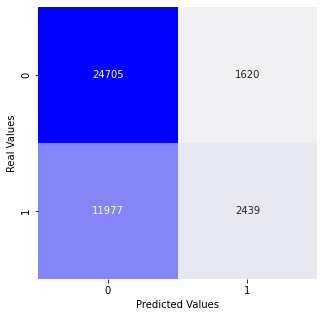

In [476]:
binary_rf_pred = rf_clf.predict(X_test)
binary_rf_train_pred = rf_clf.predict(X_train)

cr = classification_report(y_test_binary, binary_rf_pred)
cm = confusion_matrix(y_test_binary, binary_rf_pred)
print(cr)
plot_confusion_matrix(cm)

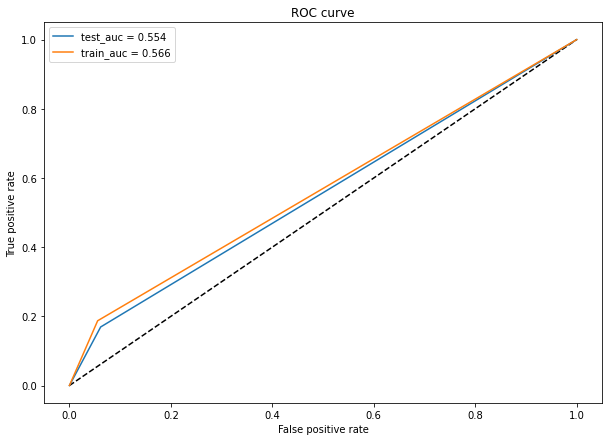

In [478]:
plot_roc_curve(y_test_binary, binary_rf_pred, y_train_binary, binary_rf_train_pred)

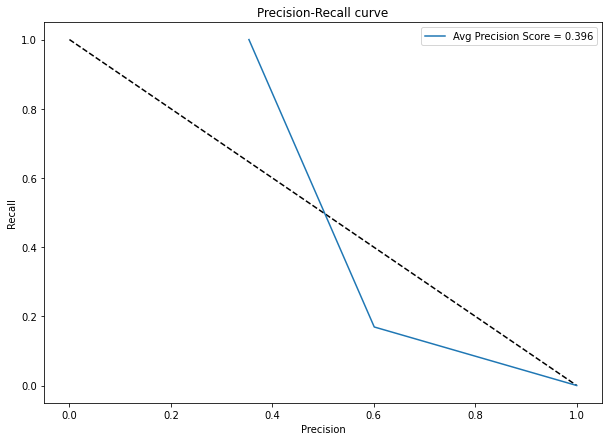

In [480]:
plot_precision_recall_curve(y_test_binary, binary_rf_pred)

### Ordinal Regression model
We'll use the package mord to create our model, and perform a grid search to find the right regularization parameter

In [455]:
from mord import LogisticIT

# defining the model
olr_model = LogisticIT(max_iter=1000, verbose=2)

# defining the hyperparameter space
# hyperparameters tuned: alpha (regularization parameter)
olr_params = {'alpha': [0, 0.5, 1, 2, 5]}
grid_search = {k: v for (k, v) in olr_params.items()}
olr_clf = GridSearchCV(olr_model, olr_params, verbose=2)

In [456]:
# training the model
olr_clf.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ............................................alpha=0; total time=   3.7s
[CV] END ............................................alpha=0; total time=   2.8s
[CV] END ............................................alpha=0; total time=   2.7s
[CV] END ............................................alpha=0; total time=   2.2s
[CV] END ............................................alpha=0; total time=   2.7s
[CV] END ..........................................alpha=0.5; total time=   3.2s
[CV] END ..........................................alpha=0.5; total time=   2.9s
[CV] END ..........................................alpha=0.5; total time=   2.4s
[CV] END ..........................................alpha=0.5; total time=   7.8s
[CV] END ..........................................alpha=0.5; total time=   6.5s
[CV] END ............................................alpha=1; total time=   8.9s
[CV] END ........................................

GridSearchCV(estimator=LogisticIT(verbose=2),
             param_grid={'alpha': [0, 0.5, 1, 2, 5]}, verbose=2)

In [490]:
# saving the model
dump(olr_clf, '../models/ordinal_lr_clf.joblib');

#### Ordinal Regression predictions and metrics

              precision    recall  f1-score   support

           0       0.50      0.00      0.00       749
           1       0.51      0.24      0.32     13667
           2       0.69      0.90      0.78     26325

    accuracy                           0.66     40741
   macro avg       0.57      0.38      0.37     40741
weighted avg       0.62      0.66      0.61     40741



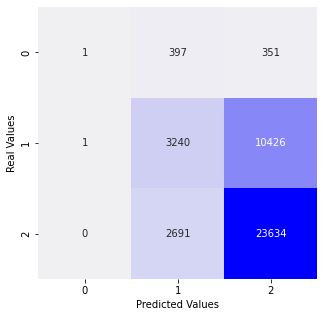

In [482]:
olr_pred = olr_clf.predict(X_test)
cr = classification_report(y_test, olr_pred)
cm = confusion_matrix(y_test, olr_pred)

print(cr)
plot_confusion_matrix(cm)

              precision    recall  f1-score   support

           0       0.17      0.00      0.00      2958
           1       0.52      0.24      0.33     54769
           2       0.69      0.90      0.78    105236

    accuracy                           0.66    162963
   macro avg       0.46      0.38      0.37    162963
weighted avg       0.62      0.66      0.61    162963



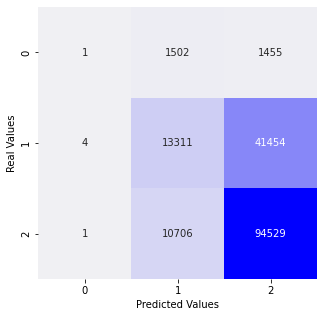

In [485]:
olr_train_pred = olr_clf.predict(X_train)
cr = classification_report(y_train, olr_train_pred)
cm = confusion_matrix(y_train, olr_train_pred)

print(cr)
plot_confusion_matrix(cm)

## Conclusions
- On balance, our best performing model was binary linear regression. It had inferior accuracy to the random forest model but decent precision, recall and f1 across the board
- The ordinal regression model had a far harder task, and indeed fell short in that it couldn't predict almost any of the fatal accidents
- At least we don't have an overfitting problem. Performance metrics for the train and test set are quite similar with all models.

### Avenues to improve the performance
Here are some ways we can improve the models we have
1. Create more features. We only used a fraction of the data we have available to us.
2. Use more aggressive dimensionality reduction, since if we add more features our training data will become even more sparse
3. Employ a feature selection algorithm
4. Widen the hyperparameter search, especially for random forest
5. Try other algorithms, such as GBT or neural networks